In [1]:
# Standard python libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from plotnine import *
import grama as gr

# Thermo specific
import CoolProp.CoolProp as CP
import CoolProp.Plots as CPP

Example optimization with grama

In [37]:
import grama as gr
md = (
    gr.Model("Constrained Rosenbrock")
    >> gr.cp_function(
        fun=lambda x: [x[0]**2 + x[1], x[1]**2 + x[0]],
        var=["x", "y"],
        out=["c", "d"],
    )
    >> gr.cp_function(
        fun=lambda x: (x[0] - 1)**3 - x[1] + 1,
        var=["x", "y"],
        out=["g1"],
    )
    >> gr.cp_function(
        fun=lambda x: x[0] + x[1] - 2,
        var=["x", "y"],
        out=["g2"],
    )
    >> gr.cp_bounds(
        x=(-1.5, +1.5),
        y=(-0.5, +2.5),
    )
)
md.printpretty()
# md >> gr.ev_min(
#     out_min="c",
#     out_leq=["g1", "g2"]
# )

model: Constrained Rosenbrock

  inputs:
    var_det:
      x: [-1.5, 1.5]
      y: [-0.5, 2.5]
    var_rand:
    copula:
        None
  functions:
    f0: ['x', 'y'] -> ['c', 'd']
    f1: ['x', 'y'] -> ['g1']
    f2: ['x', 'y'] -> ['g2']


### Grama model with Jon's original code

Issue: not framed for optimization

In [8]:
t1 = 26 + 273
t2 = 5 + 273

def set_states(t1, t2, sub):
    """
    Set all the states with one function
    Assumes quality 0 at state 3 and quality 1 at state 1
    """
    # State 1: Exiting evaporator
    q1 = 1
    h1 = CP.PropsSI('H', 'Q', q1, 'T', t1, sub)
    s1 = CP.PropsSI('S', 'Q', q1, 'T', t1, sub)

    # State 2: Exiting the turbine
    s2 = s1
    h2 = CP.PropsSI('H', 'S', s2, 'T', t2, sub)
    p2 = CP.PropsSI('P', 'S', s2, 'T', t2, sub)

    # State 3: Exiting Condensor
    t3 = t2
    q3 = 0
    h3 = CP.PropsSI('H', 'Q', q3, 'T', t3, sub)
    s3 = CP.PropsSI('S', 'Q', q3, 'T', t3, sub)
    p3 = p2

    # State 4: Exiting Pump
    s4 = s3
    p4 = CP.PropsSI('P', 'Q', q1, 'T', t1, sub)
    h4 = CP.PropsSI('H', 'S', s4, 'P', p4, sub)
    t4 = CP.PropsSI('T', 'H', h4, 'S', s4, sub)
    
    p1 = p4
    
    return [p1, h1, s1, p2, h2, s2, t3, p3, h3, s3, t4, p4, h4, s4]


states = ['p1', 'h1', 's1', 'p2', 'h2', 's2', 't3', 'p3', 'h3', 's3', 't4', 'p4', 'h4', 's4']

md_rank = (
    gr.Model()
    >> gr.cp_function(
        fun = lambda X: set_states(X[0], X[1], X[2]),
        var = ['t1', 't2', 'fluid'],
        out = states
    )
    >> gr.cp_function(
        fun = lambda X: X[0] - X[1],
        var = ['h1', 'h2'],
        out = ['eff']
    )
    
    # Goal: plug in some string for 'fluid'
    # minimize the function here
#     >> gr.ev_min(
#         out_min = "eff"
#     )
)

md_rank.printpretty()

# gr.eval_df(md_rank, gr.df_make(t1 = 303, t2 = np.linspace(278, 280, 3), fluid = ['NH3']))

model: None

  inputs:
    var_det:
      t2: (unbounded)
      fluid: (unbounded)
      t1: (unbounded)
    var_rand:
    copula:
        None
  functions:
    f0: ['t1', 't2', 'fluid'] -> ['p1', 'h1', 's1', 'p2', 'h2', 's2', 't3', 'p3', 'h3', 's3', 't4', 'p4', 'h4', 's4']
    f1: ['h1', 'h2'] -> ['eff']


### Visualizing entropy at different pressures and temperatures
Still need to frame as optimization

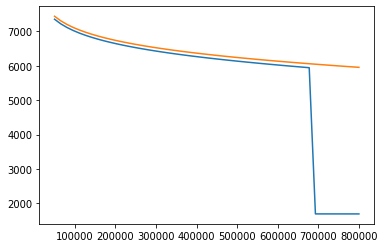

In [28]:
t_sww = 30 + 273
t_swc = 5 + 273
t_pinch = 5
t_off = 3
t1 = t_sww - t_pinch
t2 = t_swc + t_pinch + t_off

p_lo = np.linspace(50000, 800000)
s_lo = CP.PropsSI('S', 'T', t2, 'P', p_lo, 'NH3')
# p_hi = np.linspace(100000, 700000)
s_hi = CP.PropsSI('S', 'T', t1, 'P', p_lo, 'NH3')

plt.plot(p_lo, s_lo)
plt.plot(p_lo, s_hi)
plt.show()



### Attempt to find pressures by setting constraints on enthalpy changes and entropy equality
Doesn't work because I treated p1 and p2 as det vars, but p2 is actually set by t2 since we're in the vapor dome. Conclusion -> h2 should be found and then entropy difference should be minimized

In [59]:
md_pres = (
    gr.Model()
    >> gr.cp_function(
        fun = lambda X: (
            abs(CP.PropsSI('H', 'T', t2, 'P', X[0], 'NH3') - CP.PropsSI('H', 'T', t1, 'P', X[1], 'NH3') - 125000/15)
        ),
        var = ['p2', 'p1'],
        out = ['obj']
    )
    >> gr.cp_function(
        fun = lambda X: (
            abs(CP.PropsSI('S', 'T', t2, 'P', X[0], 'NH3') - CP.PropsSI('S', 'T', t1, 'P', X[1], 'NH3') - 0.1)
        ),
        var = ['p2', 'p1'],
        out = ['m']
    )
    >> gr.cp_bounds(
        p1 = (CP.PropsSI('P', 'T', t1, 'Q', 1, 'NH3'), 2e6),
        p2 = (CP.PropsSI('P', 'T', t2, 'Q', 0, 'NH3'), CP.PropsSI('P', 'T', t2, 'Q', 1, 'NH3'))
    )

)


md_pres.printpretty()

model: None

  inputs:
    var_det:
      p2: [677607.4415390701, 677607.4415390701]
      p1: [998067.740297229, 2000000.0]
    var_rand:
    copula:
        None
  functions:
    f0: ['p2', 'p1'] -> ['obj']
    f1: ['p2', 'p1'] -> ['m']


In [60]:
md_pres >> gr.ev_min(
    out_min = 'obj', 
    out_leq = 'm',
    n_restart = 20
)

Design runtime estimates unavailable; model has no timing data.


ValueError: Saturation pressure [677607 Pa] corresponding to T [286 K] is within 1e-4 % of given p [677607 Pa] : PropsSI("H","T",286,"P",677607.4415,"NH3")

### Attempt to minimize the difference in entropy given enthalpy constraint

In [70]:
md_pres2 = (
    gr.Model()
    >> gr.cp_function(
        fun = lambda X: (
            CP.PropsSI('H', 'T', t2, 'S', X[0], 'NH3')
        ),
        var = ['s2'],
        out = ['h2']
    )
    >> gr.cp_function(
        fun = lambda X: (
            CP.PropsSI('H', 'T', t2, 'S', X[0], 'NH3') - CP.PropsSI('H', 'T', t1, 'P', X[1], 'NH3') - 125000/15 - 0.1
        ),
        var = ['s2', 'p1'],
        out = ['m']
    )
    >> gr.cp_function(
        fun = lambda X: (
            abs(X[0] - CP.PropsSI('S', 'T', t1, 'P', X[1], 'NH3'))
        ),
        var = ['s2', 'p1'],
        out = ['obj']
    )
    >> gr.cp_bounds(
        p1 = (CP.PropsSI('P', 'T', t1, 'Q', 1, 'NH3'), 2e6),
        s2 = (100, 10000)
#         p2 = (CP.PropsSI('P', 'T', t2, 'Q', 0, 'NH3'), CP.PropsSI('P', 'T', t2, 'Q', 1, 'NH3'))
    )

)
md_pres2.printpretty()

model: None

  inputs:
    var_det:
      s2: [100, 10000]
      p1: [998067.740297229, 2000000.0]
    var_rand:
    copula:
        None
  functions:
    f0: ['s2'] -> ['h2']
    f1: ['s2', 'p1'] -> ['m']
    f2: ['s2', 'p1'] -> ['obj']


In [71]:
md_pres2 >> gr.ev_min(
    out_min = 'obj',
    out_leq = 'm'
)

,s2,p1,s2_0,p1_0,obj,m,h2,success,message,n_iter
0,1887.271844,1.499034e+06,5050.0,1.499034e+06,2.304569e-08,-10816.657385,460176.974916,True,Optimization terminated successfully,11


In [65]:
p1 = np.linspace(800000, 1.2e6)
h1 = CP.PropsSI('H', 'T', t1, 'P', p1, 'NH3')


In [52]:
sub = 'NH3'
t_sww = 30 + 273
t_swc = 5 + 273
t_pinch = 5
t_off = 3
t1 = t_sww - t_pinch
t2 = t_swc + t_pinch + t_off
t3 = t2
p3 = CP.PropsSI('P', 'T', t3, 'Q', 0, sub)
p2 = p3
p2
s2 = CP.PropsSI('S', 'P', p2, 'T', t2, sub)

ValueError: Saturation pressure [677607 Pa] corresponding to T [286 K] is within 1e-4 % of given p [677607 Pa] : PropsSI("S","P",677607.4415,"T",286,"NH3")

- Organic Rankine Cycle (ORC)
- Gross electric power has been previously set

## Vera parameters


| character | Parameter | Unit |
| ------- | ----------- | ---- |
|  | Working Fluid    |	[-] |
|  | gross electric power  |	[kW] |
|  | surface water temp    |	[K] |
|  | surface water temp variation    |	[K] |
|  | deep water temp    |	[K] |
|  | deep water temp variation    |	[K] |
|  | heat exchanger area    |	[$m^2$] |
|  | operating pressure    |	[Pa] |
|  | condenser temperature    |	[K] |
|  | evaporator temperature    |	[K] |
|  | pinch temperature    | [K]	|
|  |     |	|
|  |     |	|
|  |     |	|
|  |     |	|






### Seawater pipe design

| character | Parameter | Unit |
| ------- | ----------- | ---- |
|  | sw density    |	[] |
|  | sw mass flow    |	[] |
|  | sw velocity    |	[] |
|  | sw pipe material    |	[] |
|  | sw pipe length    |	[] |
|  | sw pipe diameter    |	[] |
|  | sw pipe roughness    |	[] |
|  | sw pump isentropic efficiency    |	[] |
|  | sw pump electro mechanical efficiency    |	[] |



### Model outputs
- thermodynamic efficiency
- net electric efficiency
- net electric power
- pumping losses

In [49]:
# Heat exchangers

df_data = gr.df_make(
    t_pinch = 5, # [K]
    t_var = 3, # [K]
    t_sww_in = 30 + 273, # [K] warm seawater (sw) temp
    t_swc_in = 5 + 273, # [K] deep sw temp
    sal = 0.01, # [] Salinity
    m_dot_sw = 1, # [kg/s]
#     m_dot_wf = 1, # [kg/s]
    p_cond = 2e5, # [Pa]
    p_evap = 6.5e5, # [Pa]
    fluid = ["NH3"]
)

def heat_add(df):
# Assuming seawater pressure is close to ambient
# Enthalpy of seawater at inlet
    h_sww_in = CP.PropsSI('H', 'T', df.t_sww_in, 'P', 101000, 'INCOMP::MITSW[%s]' % (str(sal)))

# Enthalpy of seawater at outlet
    t_sww_ex = df.t_sww_in - df.t_var
    h_sww_ex = CP.PropsSI('H', 'T', t_sww_ex, 'P', 101000, 'INCOMP::MITSW[%s]' % (str(sal)))

# Change in seawater enthalpy
    dh_sw = h_sww_ex - h_sww_in

# Find enthalpy of working fluid at the END of heat transfers
    t_wf_evap = t_sww_ex - df.t_pinch
    h_wf_evap = CP.PropsSI('H', 'T', t_wf_evap, 'P', df.p_evap, df.fluid[0])
    
# Calculate the required mass flow rate of the working fluid
    m_dot_wf = 
    
heat_add(df_data)


In [48]:
type(df_data.fluid[0])

str

### Grama model of rankine cycle

model: None

  inputs:
    var_det:
      t1: (unbounded)
      t2: (unbounded)
      fluid: (unbounded)
    var_rand:
    copula:
        None
  functions:
    f0: ['t1', 't2', 'fluid'] -> ['p1', 'h1', 's1', 'p2', 'h2', 's2', 't3', 'p3', 'h3', 's3', 't4', 'p4', 'h4', 's4']


,t1,t2,fluid,h3,p1,h1,p2,s2,s4,t3,h4,t4,h2,p3,s1,s3,p4
0,303,278.0,NH3,368149.143743,1.161343e+06,1.631758e+06,512788.906763,5748.20922,1564.569596,278.0,369175.125353,278.135918,1.531201e+06,512788.906763,5748.20922,1564.569596,1.161343e+06
1,303,279.0,NH3,372800.130663,1.161343e+06,1.631758e+06,531484.193635,5748.20922,1581.163405,279.0,373798.732679,279.133431,1.535406e+06,531484.193635,5748.20922,1581.163405,1.161343e+06
2,303,280.0,NH3,377457.200034,1.161343e+06,1.631758e+06,550704.374464,5748.20922,1597.716390,280.0,378427.475698,280.130766,1.539595e+06,550704.374464,5748.20922,1597.716390,1.161343e+06


### Me building a grama model of a simple refrigeration cycle two ways and finding little value in the result

In [2]:
i0 = ["t_c", "fluid"]
o0 = ["h1", "s12"]

i1 = ["t_h", "s12", "fluid"]
o1 = ["h2", "p23"]


md_ref = (
    gr.Model("project prep")
    >> gr.cp_vec_function(
        fun=lambda df: gr.df_make(
            t_h = df.t_a + df.t_off
        ),
        var = ["t_a", "t_off"],
        out = ["t_h"]
    )
    >> gr.cp_function(
        fun = lambda X: 
        [
            CP.PropsSI('H', 'T', X[0], 'Q', 1, X[1]),
            CP.PropsSI('S', 'T', X[0], 'Q', 1, X[1])
        ], 
        var = i0,
        out = o0
    )

    >> gr.cp_function(
        fun = lambda X: 
        [
            CP.PropsSI('H', 'T', X[0], 'S', X[1], X[2]),
            CP.PropsSI('P', 'T', X[0], 'S', X[1], X[2])
        ],
        var = i1,
        out = o1
    )

    >> gr.cp_function(
        fun = lambda X: CP.PropsSI('H', 'P', X[0], 'Q', 0, X[1]),
        var = ["p23", "fluid"],
        out = ["h34"]
    )

    >> gr.cp_vec_function(
        fun = lambda df: gr.df_make(
            q_b = df.m_b * df.cp_b * df.cool_rate
        ),
        var = ["m_b", "cp_b", "cool_rate"],
        out = ["q_b"]
    )
    >> gr.cp_vec_function(
    fun = lambda df: gr.df_make(
        m_dot_r = df.q_b / (df.h1 - df.h4)
    ),
        var = ["q_b", "h1", "h34"],
        out = ["m_dot_r"]
    )
    >> gr.cp_vec_function(
    fun = lambda df: gr.df_make(
        w_r = df.m_dot_r * (df.h2 - df.h1)
    ),
        var = ["m_dot_r", "h2", "h1"],
        out = ["w_r"]
    )
    >> gr.cp_vec_function(
    fun = lambda df: gr.df_make(
        q_r = df.m_dot_r * (df.h3 - df.h2)
    ),
        var = ["m_dot_r", "h34", "h2"],
        out = ["q_r"]
    )
)


md_ref.printpretty()

model: project prep

  inputs:
    var_det:
      t_a: (unbounded)
      cp_b: (unbounded)
      t_off: (unbounded)
      t_c: (unbounded)
      m_b: (unbounded)
      cool_rate: (unbounded)
      fluid: (unbounded)
    var_rand:
    copula:
        None
  functions:
    f0: ['t_a', 't_off'] -> ['t_h']
    f1: ['t_c', 'fluid'] -> ['h1', 's12']
    f2: ['t_h', 's12', 'fluid'] -> ['h2', 'p23']
    f3: ['p23', 'fluid'] -> ['h34']
    f4: ['m_b', 'cp_b', 'cool_rate'] -> ['q_b']
    f5: ['q_b', 'h1', 'h34'] -> ['m_dot_r']
    f6: ['m_dot_r', 'h2', 'h1'] -> ['w_r']
    f7: ['m_dot_r', 'h34', 'h2'] -> ['q_r']


In [12]:
md_ref_long = (
    gr.Model("project prep")
    >> gr.cp_vec_function(
        fun=lambda df: gr.df_make(
            t_h = df.t_a + df.t_off
        ),
        var = ["t_a", "t_off"],
        out = ["t_h"]
    )
    >> gr.cp_bounds(
        t_off = (0,np.inf),
        t_a = (0,np.inf)
    )
    >> gr.cp_function(
        fun = lambda X: CP.PropsSI('H', 'T', X[0], 'Q', 1, X[1]),
        var = ["t_c", "fluid"],
        out = ["h1"]
    )
    >> gr.cp_function(
        fun = lambda X: CP.PropsSI('S', 'T', X[0], 'Q', 1, X[1]),
        var = ["t_c", "fluid"],
        out = ["s1"]
    )
    >> gr.cp_function(
        fun = lambda X: X[0],
        var = ["s1"],
        out = ["s2"]
    )
    >> gr.cp_function(
        fun = lambda X: CP.PropsSI('H', 'T', X[0], 'S', X[1], X[2]),
        var = ["t_h", "s2", "fluid"],
        out = ["h2"]
    )
    >> gr.cp_function(
        fun = lambda X: CP.PropsSI('P', 'T', X[0], 'S', X[1], X[2]),
        var = ["t_h", "s2", "fluid"],
        out = ["p2"]
    )
    >> gr.cp_function(
        fun = lambda X: X[0],
        var = ["p2"],
        out = ["p3"]
    )
    >> gr.cp_function(
        fun = lambda X: CP.PropsSI('H', 'P', X[0], 'Q', 0, X[1]),
        var = ["p3", "fluid"],
        out = ["h3"]
    )
    >> gr.cp_function(
        fun = lambda X: X[0],
        var = ["h3"],
        out = ["h4"]
    )
    >> gr.cp_vec_function(
        fun = lambda df: gr.df_make(
            q_b = df.m_b * df.cp_b * df.cool_rate
        ),
        var = ["m_b", "cp_b", "cool_rate"],
        out = ["q_b"]
    )
    >> gr.cp_vec_function(
    fun = lambda df: gr.df_make(
        m_dot_r = df.q_b / (df.h1 - df.h4)
    ),
        var = ["q_b", "h1", "h4"],
        out = ["m_dot_r"]
    )
    >> gr.cp_vec_function(
    fun = lambda df: gr.df_make(
        w_r = df.m_dot_r * (df.h2 - df.h1)
    ),
        var = ["m_dot_r", "h2", "h1"],
        out = ["w_r"]
    )
    >> gr.cp_vec_function(
    fun = lambda df: gr.df_make(
        q_r = df.m_dot_r * (df.h3 - df.h2)
    ),
        var = ["m_dot_r", "h3", "h2"],
        out = ["q_r"]
    )
)

df_sing = gr.df_make(
    fluid = ["R134a"], 
    t_off = [5], 
    cool_rate = 2/3600,
    t_c = 273,
    m_b = 100,
    cp_b = 3600,
)
df_mult = gr.df_make(t_a = np.linspace(280, 310, 16))
df_data = gr.tran_outer(
    df_sing,
    df_mult
)

df_ref = (
    md_ref
    >> gr.ev_df(
        df = df_data
    )
)
# df_ref
plt.plot(df_ref.t_a, df_ref.w_r)
plt.show()

NameError: name 'md_ref' is not defined

In [13]:
md_ref_long.printpretty()

model: project prep

  inputs:
    var_det:
      t_a: [0, inf]
      cool_rate: (unbounded)
      fluid: (unbounded)
      t_off: [0, inf]
      m_b: (unbounded)
      t_c: (unbounded)
      cp_b: (unbounded)
    var_rand:
    copula:
        None
  functions:
    f0: ['t_a', 't_off'] -> ['t_h']
    f1: ['t_c', 'fluid'] -> ['h1']
    f2: ['t_c', 'fluid'] -> ['s1']
    f3: ['s1'] -> ['s2']
    f4: ['t_h', 's2', 'fluid'] -> ['h2']
    f5: ['t_h', 's2', 'fluid'] -> ['p2']
    f6: ['p2'] -> ['p3']
    f7: ['p3', 'fluid'] -> ['h3']
    f8: ['h3'] -> ['h4']
    f9: ['m_b', 'cp_b', 'cool_rate'] -> ['q_b']
    f10: ['q_b', 'h1', 'h4'] -> ['m_dot_r']
    f11: ['m_dot_r', 'h2', 'h1'] -> ['w_r']
    f12: ['m_dot_r', 'h3', 'h2'] -> ['q_r']
